In [3]:
#only run these lines if running a Google Colab environment
#%matplotlib inline

#from google.colab import *

#drive.mount('/content/gdrive', force_remount=True)

#%cd "/content/gdrive/My Drive/"


## MNIST Handwritten Digit Recognition in Fastai.

We will build a CNN using transfer learning in Fastai. Since we have created the Fastai environment in the Dockerfile it just remains to import fastai. This will be directed at the competition on kaggle.

In [1]:
%matplotlib inline

In [14]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy,error_rate

This is a custom ImageList that allows us to load the kaggle datasets. Essentially, the images are stored as a label plus a pixel array wrapped up in a csv file.

In [21]:
# in newer versions of fastai this is just called ImageList now
class ImageList(ImageList):
    def open(self, fn):
        img = fn.reshape(28,28)
        img = np.stack((img,)*3, axis=-1) # convert to 3 channels
        return Image(pil2tensor(img, dtype=np.float32))

    @classmethod
    def from_csv_custom(cls, path:PathOrStr, csv_name:str, imgIdx:int=1, header:str='infer', **kwargs)->'ImageList':
        df = pd.read_csv(Path(path)/csv_name, header=header)
        res = super().from_df(df, path=path, cols=0, **kwargs)
        # convert pixels to an ndarray
        res.items = df.iloc[:,imgIdx:].apply(lambda x: x.values / 255.0, axis=1).values
        return res

Pull in the test data. Note: there are no labels in a test set, so we set the imgIdx to begin at the 0 col.

In [ ]:

test = ImageList.from_csv_custom(path='./data', csv_name='test.csv', imgIdx=0)

Pull in the training data outlined by kaggle. Do some transforms on the actual data. Then show some data in a plot.

In [23]:
tfms = get_transforms(do_flip=False)
data = (ImageList.from_csv_custom(path='./data', csv_name='train.csv')
                           .random_split_by_pct(.2)
                           .label_from_df(cols='label')
                           .add_test(test, label=0)
                           .transform(tfms)
                           .databunch(bs=64, num_workers=0)
                           .normalize(imagenet_stats))

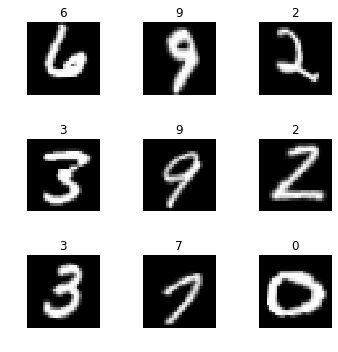

In [24]:
data.show_batch(rows=3, figsize=(5,5))

Create the model architecture and train for 2 epochs. This is fairly slow without a GPU. The models.resnet34 is a pretrained model that Fastai can use as the base of the model we are creating. This is the transfer learning. 

In [26]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy,error_rate])
learn.fit(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/dev/.torch/models/resnet34-333f7ec4.pth
87306240it [00:05, 16099722.45it/s]


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.510891,0.337832,0.891429,0.108571,07:32
1,0.297095,0.191427,0.940238,0.059762,06:42


Lr_find() and the subsequent plot are high level Fastai methods to help us decide on a learning rate. Again quite slow without the GPU.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


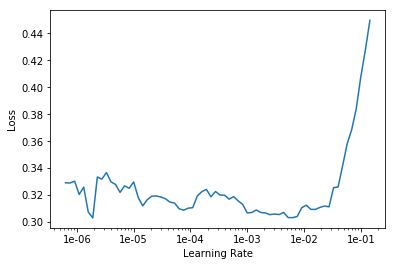

In [27]:
learn.lr_find()
learn.recorder.plot()

Set the learning rate and then train for two more cycles.

In [29]:
lr = 1e-2
learn.fit_one_cycle(2, lr)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.170365,0.119168,0.962857,0.037143,06:40
1,0.093680,0.044334,0.986667,0.013333,07:27


Save the model

In [31]:
learn.save('resnet34-stage-1')


Load the model

In [33]:
learn.load('resnet34-stage-1')


[0.044333562, tensor(0.9867), tensor(0.0133)]

Unfreezing the model is effectively making it ready to be able to fit additional cycles to the existing model. Running one additional epoch did not improve the model over our previous fit in this case.

In [34]:
learn.unfreeze()
learn.fit_one_cycle(1)


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.053497,0.025048,0.992143,0.007857,13:22


Let's interpret some output through a confusion matrix and where the model is most confused.

In [35]:
interp = ClassificationInterpretation.from_learner(learn)


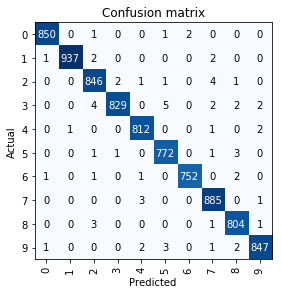

In [36]:
interp.plot_confusion_matrix()


The following shows the cases where the model is most confused. There 5 cases where an Actual 3 is predicted as a 5. 

In [37]:
interp.most_confused()


[(3, 5, 5),
 (2, 7, 4),
 (3, 2, 4),
 (5, 8, 3),
 (7, 4, 3),
 (8, 2, 3),
 (9, 5, 3),
 (0, 6, 2),
 (1, 2, 2),
 (1, 7, 2),
 (2, 3, 2),
 (3, 7, 2),
 (3, 8, 2),
 (3, 9, 2),
 (4, 9, 2),
 (6, 8, 2),
 (9, 4, 2),
 (9, 8, 2),
 (0, 2, 1),
 (0, 5, 1),
 (1, 0, 1),
 (2, 4, 1),
 (2, 5, 1),
 (2, 8, 1),
 (4, 1, 1),
 (4, 7, 1),
 (5, 2, 1),
 (5, 3, 1),
 (5, 7, 1),
 (6, 0, 1),
 (6, 2, 1),
 (6, 4, 1),
 (7, 9, 1),
 (8, 7, 1),
 (8, 9, 1),
 (9, 0, 1),
 (9, 7, 1)]

In [38]:
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)

This saves the output in format to upload to kaggle if you are so inclined.

In [81]:
res_df = pd.DataFrame({'ImageId': list(range(1,len(labels)+1)), 'Label': labels})
res_df.to_csv(f'./data/digit-recognition-submission.csv', index=False)
